<a href="https://colab.research.google.com/github/StephenTGibson/MScDataSci_21-22/blob/main/COMP702-MScProject/PINN_method_for_1D_Burgers'_equation_forward_problem_using_L_BFGS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on method presented in:  
*Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations*  
https://www.sciencedirect.com/science/article/pii/S0021999118307125?casa_token=IF_2eTCwVfkAAAAA:-AYLqjAlpXcFYBHje4sO2kMjqH3k0pdFQ7Qdpw1MazWxIGPwacb3Cp0gCtFRbNDAVLSsjCWU0g

In [1]:
# install devito
!pip install devito &> /dev/null

In [2]:
# import required libraries and tools
import numpy as np
from numpy.random import default_rng
rng = default_rng()

from time import perf_counter

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
from torch import nn

from devito import Grid, TimeFunction, Operator, Constant, Eq, solve, first_derivative, left

In [3]:
# define constants
c1 = 1.
c2 = 0.01/np.pi

In [4]:
# define discretisation

# extent x direction
X = 2.0
# number of x grid points
nx = 1001
# x direction step size
dx = X / (nx - 1)

# time extent (total duration)
T = 1 
# time step
dt = 1e-4
# number of time points
nt = int((T / dt) + 1)

In [5]:
# create 1D grid and assign dimension variable names
grid = Grid(shape=(nx), extent=(X))

x = grid.dimensions
t = grid.stepping_dim

In [6]:
# create time function on grid
# space order of 2 to enable 2nd derivative
u = TimeFunction(name='u', grid=grid, space_order=2)

In [7]:
# create constant (viscosity)
a = Constant(name='a')
b = Constant(name='b')
# define 1D Burgers' equation
equation_u = Eq(u.dt + a*u*u.dxl, b*u.dx2)
equation_u

Eq(a*u(t, x)*Derivative(u(t, x), x) + Derivative(u(t, x), t), b*Derivative(u(t, x), (x, 2)))

In [8]:
# create stencil by solving for next time step
stencil_u = solve(equation_u, u.forward)
stencil_u

dt*(-a*u(t, x)*Derivative(u(t, x), x) + b*Derivative(u(t, x), (x, 2)) + u(t, x)/dt)

In [9]:
# define equation for next time step
update_u = Eq(u.forward, stencil_u)
update_u

Eq(u(t + dt, x), dt*(-a*u(t, x)*Derivative(u(t, x), x) + b*Derivative(u(t, x), (x, 2)) + u(t, x)/dt))

In [10]:
# define boundary conditions
# u = 0 at min and max extent of x
boundaryConditions = [Eq(u[t+1, 0], 0.)]
boundaryConditions += [Eq(u[t+1, nx], 0.)]

In [11]:
# define operator based on equation and boundary conditions
op = Operator([update_u] + boundaryConditions)

In [12]:
# set solution space to 0s
u.data[:] = 0

# create a dummy x array from -1 to +1
dummyX = np.arange(-1, 1+dx, dx)

# set initial conditions using dummy x array
u.data[0] = -1 * np.sin(np.pi * dummyX)

In [ ]:
# define number of time steps to compute before storing result for plotting
batchSize = 100

# initialise empty array to store computed solution
results = np.zeros((nx, int(nt / batchSize)))
# store initial conditions in results array
results[:,0] = u.data[0].copy()

# log start time to measure performance
startTime = perf_counter()

# iterate over result steps
# start from 1 not 0 as results at step 0 are the initial conditions
for timeStep in range(1, int(nt / batchSize)):
    # compute solution after batchSize time steps
    summary = op.apply(time=batchSize, dt=dt, a=c1, b=c2)
    # store computed solution in results array
    results[:,timeStep] = u.data[0].copy()

# log end time to measure performance
endTime = perf_counter()
# print total training time
print(f'Training duration: {(endTime-startTime):.2f}s')

# Nu and Nf

In [14]:
# define spatial and temporal domain extent
xMin = -1
xMax = 1
tMin = 0
tMax = 1

In [41]:
# create dataset
# number of points initial condition and boundary points
Nu = 20

# proportion of Nu which are initial condition points
prop_ic = 0.8
# number of initial condition points
Nu_i = int(prop_ic * Nu)
# number of boundary condition points
Nu_bc = Nu - Nu_i

# number of collocation points across input domain interior
Ninterior = 2000

# total number collocation points
Nf = Ninterior + Nu

In [42]:
# uniformly randomly select some points along the x axis to generate initial condition training points
uniformRandomXArray = rng.uniform(low=xMin, high=xMax, size=Nu_i)

# create array of initial condition defined training points
# t = 0
# x = uniformly random from x domain
# u = -1*sin(pi*x)
Nu_iArray= np.array([
                   np.zeros(Nu_i),
                   uniformRandomXArray,
                   -1 * np.sin(np.pi * uniformRandomXArray)
                    ]).T

In [43]:
# uniformly randomly select some points along the time axis to generate boundary condition training points
uniformRandomTArray = rng.uniform(low=tMin, high=tMax, size=Nu_bc)

# create array of boundary condition defined training points
# t = uniformly random from time domain
# x = random choice of -1 or 1
# u = 0
Nu_bcArray = np.array([
                        uniformRandomTArray,
                        rng.choice(np.array([-1,1]), size=Nu_bc, replace=True),
                        np.zeros(Nu_bc)
                        ]).T

In [44]:
# define empty array to hold initial and boundary conditions training points
NuArray = np.zeros((Nu, 3))
# add initial condition points
NuArray[:Nu_i,:] = Nu_iArray.copy()
# add boundary condition points
NuArray[Nu_i:,:] = Nu_bcArray.copy()

In [45]:
# # shuffle initial and boundary condition training points
# rng.shuffle(NuTrainingSet)
# # convert numpy array to pytorch tensor
# NuSetTensor = torch.from_numpy(NuTrainingSet.astype(np.float32))
# # split into input and outputs for training
# # set input tensor to store calculated gradients
# NuX = NuSetTensor[:,:2].requires_grad_()
# Nuy = NuSetTensor[:,2]

In [46]:
# create collocation training points selected uniformly randomly across input domain
NinteriorArray = np.array([
               rng.uniform(tMin, tMax, Ninterior),
               rng.uniform(xMin, xMax, Ninterior),
               ]).T

NfArray = np.zeros((Nf, 2))

NfArray[:Ninterior] = NinteriorArray.copy()

NfArray[Ninterior:] = NuArray[:, :-1]

# convert numpy array to pytorch tensor and set to store calculated gradients
# NfTensor = torch.from_numpy(NfSet.astype(np.float32)).requires_grad_()

In [47]:
NuArray.shape

(20, 3)

## PINN

In [48]:
# plot training loss curve
def trainingLossPlot(history):
    fig, ax = plt.subplots(figsize=(6,4))

    # plot losses
    ax.plot(history[:,0], label='Total loss')
    ax.plot(history[:,1], label='Solution loss')
    ax.plot(history[:,2], label='Residual loss')
    # add legend
    ax.legend(loc=(1.01, 0.5))
    # label axes
    ax.set_xlabel('Training epoch')
    ax.set_ylabel('Loss')
    # add an insert ax in top right corner
    axins = ax.inset_axes([0.5, 0.5, 0.46, 0.46])
    # plot losses on insert ax
    axins.plot(history[:,0])
    axins.plot(history[:,1])
    axins.plot(history[:,2])
    # set limits of insert ax
    axins.set_xlim(3*epochs//4, epochs)
    # axins.set_ylim(0, 1)
    # remove x axis labels
    axins.set_xticklabels([])
    # add insert locator lines
    ax.indicate_inset_zoom(axins, edgecolor="black")
    # figure title
    fig.suptitle("1D Burgers' equation PINN training loss", fontsize=16)

    plt.show()

    # fig.savefig("1D Burgers' - PINN training loss", bbox_inches='tight')

In [49]:
# function to create arrays for plotting results
# input: x and y dimensions of solution space to plot
# output: 
# X and Y, 2D numpy arrays and size y*x to plot a matplotlib mesh
# U, 2D numpy array containing PINN approximated solution for all points within mesh
# R, 2D numpy array containing computed residual for all points within mesh
def meshPlotData(xDim, yDim):
    
    # create np arrays based on input domain extent and dimensions of mesh for plotting
    x = np.arange(tMin, tMax, (tMax-tMin)/xDim)
    y = np.arange(xMin, xMax, (xMax-xMin)/yDim)
    # create meshgrid arrays
    X, Y = np.meshgrid(x, y)

    # create empty array to contain all meshgrid points
    flattenedCoords = np.zeros(((xDim)*(yDim), 2))
    # add meshgrid points, X ~ t and Y ~ x
    flattenedCoords[:,0] = X.flatten()
    flattenedCoords[:,1] = Y.flatten()
    # convert numpy array to pytorch tensor
    flattenedCoords = torch.from_numpy(flattenedCoords.astype(np.float32))

    # use PINN to approximate solution for all points
    flattenedU = model(flattenedCoords[:,0], flattenedCoords[:,1])
    # reshape solution array into meshgrid shape and convert to numpy
    U = torch.reshape(flattenedU, (yDim, xDim)).detach().numpy()

    # # set flattened points to retain gradients during computation
    # flattenedCoords = flattenedCoords.requires_grad_()
    # # compute residual at all points
    # flattened_R = model.residual(flattenedCoords)
    # # reshape residual array into meshgrid shape and convert to numpy
    # R = torch.reshape(flattened_R, (yDim, xDim)).detach().numpy()

    return X, Y, U#, R

In [50]:
# define neural network architecture

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        # self.l1 = nn.Parameter(torch.tensor(1.))
        # self.l2 = nn.Parameter(torch.tensor(0.003))



        self.linear_stack = nn.Sequential(
            nn.Linear(2, 20),
            nn.Tanh(),            
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),            
            nn.Linear(20, 20),
            nn.Tanh(),            
            nn.Linear(20, 20),         
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),            
            nn.Linear(20, 1),
        )            

        self.optimiser = torch.optim.LBFGS(self.parameters(),
                                           lr=1,
                        history_size=10,
                        max_iter=50,
                        line_search_fn="strong_wolfe"
                        )

        self.l1 = torch.tensor(1.)
        self.l2 = torch.tensor(0.01/np.pi)

    def forward(self, t, x):
        return self.linear_stack(torch.stack((t, x)).T)

    def residual(self, t, x):
        # compute neural network solution approximations
        u = self.forward(t, x).flatten()

        # print(u.shape)

        ut = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
        ux = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0] 
        uxx = torch.autograd.grad(ux, x, torch.ones_like(ux), create_graph=True)[0]

        # print(ut.shape)
        # print(ux.shape)
        # print(uxx.shape)

        # compute and return residual using 1D burgers' equation
        return ut + self.l1 * u * ux - self.l2 * uxx #.flatten()

    def lossFunc(self, D, Y, R):
        solutionLoss = torch.mean(torch.square(D - Y))
        residualLoss = torch.mean(torch.square(R))        
        return solutionLoss + residualLoss, solutionLoss, residualLoss

    def trainingFunction(self, epochs, NuArray, NfArray):
        self.train()
        
        # initialise empty lists to store loss during at each stage of training
        lossHistory = []
        solutionLossHistory = []
        residualLossHistory = []

        # l1History = []
        # l2History = []
        
        # Nu
        Nu_t = torch.from_numpy(NuArray[:,0].astype(np.float32)).requires_grad_()
        Nu_x = torch.from_numpy(NuArray[:,1].astype(np.float32)).requires_grad_()
        Nu_d = torch.from_numpy(NuArray[:,2].astype(np.float32).reshape(NuArray.shape[0],1))

        # Nf
        Nf_t = torch.from_numpy(NfArray[:,0].astype(np.float32)).requires_grad_()
        Nf_x = torch.from_numpy(NfArray[:,1].astype(np.float32)).requires_grad_()

        startTime = perf_counter()

        for epoch in range(epochs):            
            def closure():
                self.optimiser.zero_grad()
                Nu_u = self.forward(Nu_t, Nu_x)
                Nf_r = self.residual(Nf_t, Nf_x)
                lossValue = self.lossFunc(Nu_d, Nu_u, Nf_r)[0]                
                lossValue.backward()
                return lossValue
            self.optimiser.step(closure)

            lossComponents = self.lossFunc(Nu_d, self.forward(Nu_t, Nu_x), self.residual(Nf_t, Nf_x))
            lossHistory.append(lossComponents[0].item())
            solutionLossHistory.append(lossComponents[1].item())
            residualLossHistory.append(lossComponents[2].item())                 

        # l1History.append(self.l1.item())
        # l2History.append(self.l2.item())

            # print training progress update
            if epoch > 0 and epoch % (epochs // 10) == 0:
                # log end time to measure performance
                endTime = perf_counter()
                # print total training time
                print(f'Epoch: {epoch} --- Elapsed time: {(endTime-startTime):.2f}s --- Loss: {lossHistory[-1]}')

        return np.array([lossHistory, solutionLossHistory, residualLossHistory]).T#, l1History, l2History]).T

Network parameters: 2601
Epoch: 10 --- Elapsed time: 23.81s --- Loss: 0.03497420251369476
Epoch: 20 --- Elapsed time: 45.36s --- Loss: 0.01771886646747589
Epoch: 30 --- Elapsed time: 65.10s --- Loss: 0.002704982878640294
Epoch: 40 --- Elapsed time: 86.15s --- Loss: 0.0007762355962768197
Epoch: 50 --- Elapsed time: 106.14s --- Loss: 0.0004083247040398419
Epoch: 60 --- Elapsed time: 126.23s --- Loss: 0.00019013546989299357
Epoch: 70 --- Elapsed time: 146.75s --- Loss: 0.00011964520672336221
Epoch: 80 --- Elapsed time: 167.01s --- Loss: 8.999762940220535e-05
Epoch: 90 --- Elapsed time: 187.39s --- Loss: 6.1266306147445e-05


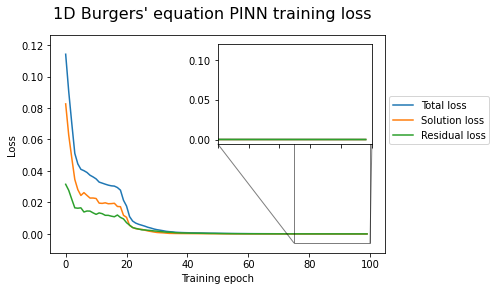

In [53]:
# create new network and print number of trainable parameters
model = NeuralNetwork()
print(f'Network parameters: {sum(p.numel() for p in model.parameters())}')

# number of training iterations
epochs = 100

history = model.trainingFunction(epochs, NuArray, NfArray)

trainingLossPlot(history)

plt.show()

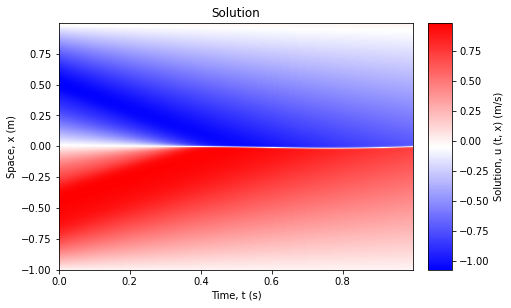

In [55]:
# set model in evaluation mode
model.eval()
# compute meshgrid, solution and residual for plotting
X, Y, U = meshPlotData(1000, 1000)

fig = plt.figure(
    figsize=(12, 6),
    constrained_layout=True
    )
gs = GridSpec(3, 20, figure=fig)

# add solution plot
solutionAx = fig.add_subplot(gs[:2,:10])
solutionPlot = solutionAx.pcolormesh(X, Y, U, cmap='bwr')#, vmin=-1, vmax=1)
# solutionAx.set_xlim([0, 1])
# solutionAx.set_ylim([-1, 1])

solutionAx.set_title('Solution')
solutionAx.set_xlabel('Time, t (s)')
solutionAx.set_ylabel('Space, x (m)')
cbar = fig.colorbar(solutionPlot, use_gridspec=True)
cbar.set_label('Solution, u (t, x) (m/s)')

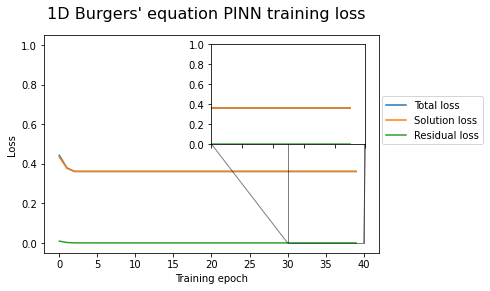

In [ ]:
# print(f'lambda1: {model.state_dict()["l1"]}')
# print(f'lambda2: {model.state_dict()["l2"]}')

trainingLossPlot(history)

# plt.plot(history[:,3], label='l1 ~1.0')
# plt.plot(history[:,4], label='l2 ~0.0032')
# plt.legend()

In [ ]:
    # set model in evaluation mode
    model.eval()
    # compute meshgrid, solution and residual for plotting
    X, Y, U, R = meshPlotData(1000, 1000) 

### Training and results

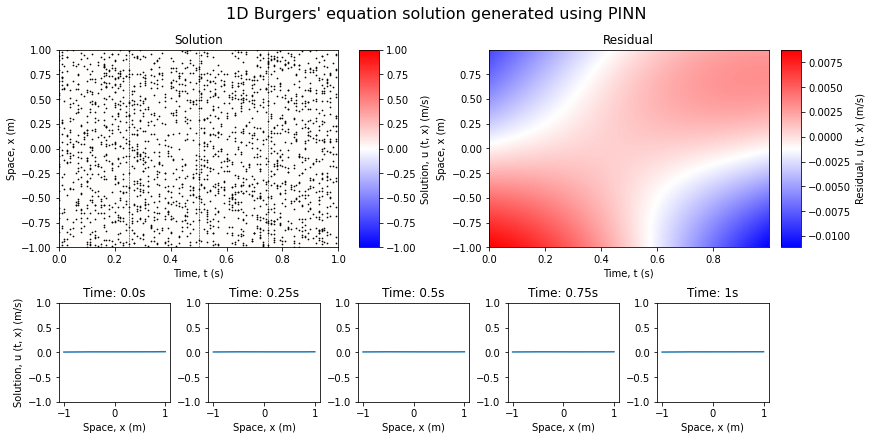

In [ ]:
# create figure using gridspec to structure subplots
fig = plt.figure(
    figsize=(12, 6),
    constrained_layout=True
    )
gs = GridSpec(3, 20, figure=fig)

# add solution plot
solutionAx = fig.add_subplot(gs[:2,:10])
solutionPlot = solutionAx.pcolormesh(X, Y, U, cmap='bwr', vmin=-1, vmax=1)
solutionAx.set_xlim([0, 1])
solutionAx.set_ylim([-1, 1])

solutionAx.set_title('Solution')
solutionAx.set_xlabel('Time, t (s)')
solutionAx.set_ylabel('Space, x (m)')
cbar = fig.colorbar(solutionPlot, use_gridspec=True)
cbar.set_label('Solution, u (t, x) (m/s)')

# solutionAx.scatter(    
#     trainingArray[:,0],
#     NuArray[:,1],    
#     s=100.,
#     c='k',
#     marker='x'
# )

solutionAx.scatter(    
    trainingArray[:,0],
    trainingArray[:,1],    
    s=2.,
    c='k',
    marker='.'
)

# add residual plot
residualAx = fig.add_subplot(gs[:2,10:])
residualPlot = residualAx.pcolormesh(X, Y, R, cmap='bwr')
residualAx.set_title('Residual')
residualAx.set_xlabel('Time, t (s)')
residualAx.set_ylabel('Space, x (m)')
cbar = fig.colorbar(residualPlot, use_gridspec=True)
cbar.set_label('Residual, u (t, x) (m/s)')

# iteratively create solution snapshot subplots
for i in range(5):
    tPlot = fig.add_subplot(gs[2, i*4:(i+1)*4])    
    if i < 4:
        tPlot.plot(Y[:, i*(Y.shape[1]//4)], U[:, i*(Y.shape[1]//4)])
        tPlot.set_title('Time: ' + str(i*X[0, X[0].shape[0]//4]) + 's')
        # add vertical lines to solution plot to indicate snapshots
        solutionAx.vlines(x=i*X[0, X[0].shape[0]//4], ymin=Y[0,0], ymax=Y[-1,0], colors='black', ls='--', lw=0.5)
    else:
        tPlot.plot(Y[:, -1], U[:, -1])
        tPlot.set_title('Time: ' + str(tMax) + 's')
    
    tPlot.set_ylim([-1, 1])
    tPlot.set_xlabel('Space, x (m)')
    if i == 0:
        tPlot.set_ylabel('Solution, u (t, x) (m/s)')

# figure title
fig.suptitle("1D Burgers' equation solution generated using PINN", fontsize=16)

# fig.savefig("1D Burgers' solution - PINN", bbox_inches='tight')
plt.show()

lambda1: 9.900162696838379
lambda2: 9.900165557861328


https://visualstudiomagazine.com/articles/2021/06/23/logistic-regression-pytorch.aspx

SyntaxError: ignored